In [346]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import pandas as pd
import networkx as nx
from sklearn import cluster, covariance, manifold
import ipywidgets as widgets
from IPython.display import display 
import edhec_risk_kit as erk
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [347]:
def sparsity(alpha):
    true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                      [0.0, 0.4, 0.0, 0.0],
                      [0.2, 0.0, 0.3, 0.1],
                      [0.0, 0.0, 0.1, 0.7]])
    np.random.seed(0)
    X = np.random.multivariate_normal(mean=[0, 0, 0, .01],
                                   cov=true_cov,
                                   size=200)
    X=erk.get_ind_returns().values
    columns=erk.get_ind_returns().columns
    cov = covariance.GraphicalLasso(alpha=alpha,max_iter=1000).fit(X)
    A=np.around(cov.precision_, decimals=3)
    G=nx.from_numpy_matrix(A,create_using=nx.Graph())
    pos=nx.spring_layout(G)        
    nx.draw(G,pos,with_labels=False,node_color='r',node_size=30)
    labels={}
    for p in pos:  # raise text positions
        pos[p][1] += 0.08
        labels.update({p:columns[p]})
    
    nx.draw_networkx_labels(G, pos,labels=labels)
    
    plt.show()

In [348]:
sparse_control=widgets.interactive(sparsity,
                                  alpha=(0.,.01,.0001)
                                  )

In [349]:
display(sparse_control)

interactive(children=(FloatSlider(value=0.005, description='alpha', max=0.01, step=0.0001), Output()), _dom_cl…

In [350]:
true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                      [0.0, 0.4, 0.0, 0.0],
                      [0.2, 0.0, 0.3, 0.1],
                      [0.0, 0.0, 0.1, 0.7]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, .01],
                                   cov=true_cov,
                                   size=200)

In [351]:
cov = covariance.GraphicalLasso(0.1).fit(X)
A=np.around(cov.precision_, decimals=3)

In [352]:
X.shape

(200, 4)

In [353]:
def cross_validated_GraphicalLasso(data,alphaMax,nLambdas:int,StockNames=None,frac=0.1):
    '''cross_validated_lasso_regression takes in a dataset and returns the factor loadings using lasso regression and cross validating the choice of lambda
    INPUTS:
        data: pandas df, data matrix, should constain the date column and all of the factorNames columns
        dependentVar: string, name of dependent variable
        factorNames: list, elements should be strings, names of the independent variables
        options: dictionary, should constain at least two elements, timeperiod, and date
            timeperiod: string, if == all, means use entire dataframe, otherwise filter the df on this value
            date: name of datecol
            returnModel: boolean, if true, returns model
            printLoadings: boolean, if true, prints the coeficients

            maxLambda: float, max lambda value passed
            nLambdas: int, number of lambda values to try
            randomState: integer, sets random state seed
            nFolds: number of folds
            NOTE: SKLearn calles Lambda Alpha.  Also, it uses a scaled version of LASSO argument, so here I scale when converting lambda to alpha
    Outputs:
        reg: regression object from sikitlearn
        also prints what was desired
    '''

    #Do CV Lasso
    alphas = np.linspace(0.001,alphaMax,nLambdas)
    graph={}
    for alpha in alphas:
        P=compute_precision(alpha,data,frac)
        check=np.count_nonzero(P,axis=1)==1
        if check.sum()>=5:
            graph={"index":np.where(check==1),
                    "Precision":P,
                    "Alpha":alpha,
                    "Names":data.columns}
            break
    return graph

In [354]:
def compute_precision(alpha,data,frac,n_samples=10):
    '''
    Compute the average precision matrix of n subsamples given size n and alpha value
    '''
    
    d=data.shape[1]
    S=np.zeros((d,d))
    for i in range(1,n_samples):
        SampleX=data.sample(frac=frac).values
        cov = covariance.GraphicalLasso(alpha=alpha,max_iter=1000).fit(SampleX)
        S=S+cov.precision_
    return S/n_samples

In [355]:
 X=erk.get_ind_returns()

In [356]:
Results=cross_validated_GraphicalLasso(X,0.01,1000,frac=0.1)

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.216e-03
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.824e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -4.827e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -4.807e-03
  % (max_iter, d_gap), 

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 4.075e-03
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.319e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.255e-03
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -4.919e-04
  % (max_iter, d_gap), C

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.663e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.080e-03
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.036e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -6.307e-04
  % (max_iter, d_gap), 

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 5.503e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.207e-03
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -7.987e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.425e-03
  % (max_iter, d_gap), C

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 3.878e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.036e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.289e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.468e-04
  % (max_iter, d_gap), C

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.324e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 7.834e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 1.528e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -3.905e-04
  % (max_iter, d_gap), Co

C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -1.060e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.958e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -2.445e-04
  % (max_iter, d_gap), ConvergenceWarning)
C:\Users\HerveTwahirwa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\covariance\_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: 3.625e-04
  % (max_iter, d_gap), C

In [357]:
def Graph_Sparsity(Results):
    columns=Results['Names']
    idx=Results['index'][0]
    A=np.around(Results['Precision'], decimals=3)
    G=nx.from_numpy_matrix(A,create_using=nx.Graph())
    pos=nx.spring_layout(G)        
    nx.draw(G,pos,with_labels=False,node_size=30,node_color='r')
    labels={}
    for p in pos:  # raise text positions
        pos[p][1] += 0.08
        labels.update({p:columns[p]})
    
    nx.draw_networkx_labels(G, pos,labels=labels)
    plt.show()
    print(columns[idx])

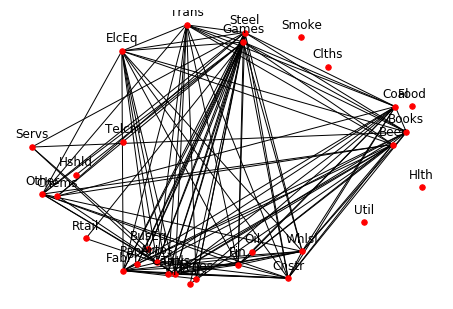

Index(['Food', 'Smoke', 'Clths', 'Hlth', 'Util', 'Telcm'], dtype='object')


In [358]:
Graph_Sparsity(Results)

In [359]:
Results['Alpha']

0.004027027027027027